# Tutorial on Parallelized Calculations

This tutorial demonstrates how to use QuantumDNA to calculate a range of observables that characterize the electronic and dynamic properties of DNA systems. By leveraging efficient computation and parallelization capabilities, you can analyze large datasets and complex systems.

Observables Covered:

* **Exciton Lifetime (femtoseconds)**
Estimate the lifetime of excitons, which play a critical role in energy transport and recombination processes within DNA.

* **Average Charge Separation (Å)**
Compute the spatial separation between electrons and holes, providing insights into charge transfer efficiency and molecular stability.

* **Dipole Moment (Debye)**
Analyze the molecular dipole moment, an important property that governs interactions with external fields and other molecules.

* **Average Exciton Population on Upper and Lower DNA Strands**
Quantify the distribution of exciton populations between the two DNA strands, shedding light on strand-specific dynamics and energy transport.

Example Application:
As an illustrative example, the calculations are applied to all 64 possible DNA trimer/triplet sequences, allowing for a systematic investigation of how sequence composition influences these properties. This analysis showcases the versatility of the package for exploring sequence-dependent electronic characteristics.

By the end of this notebook, you will have an understanding of how to perform these calculations and utilize QuantumDNA's parallelization features to efficiently analyze large-scale systems.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/dehe1011/QuantumDNA-notebooks/blob/main/tutorials/5_Evaluation.ipynb)

In [2]:
%load_ext autoreload
%autoreload 2

# Save flag: Set to True to enable saving results (currently unused in this script)
save = False

# Verbose flag: Set to True to enable detailed logging
verbose = False

## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Installation of QuantumDNA
# --------------------------

from importlib.util import find_spec

qDNA_installed = find_spec('qDNA') is not None

if not qDNA_installed:
    %pip install qDNA
    print("Successfully installed the 'qDNA' package.")
else:
    print("Package 'qDNA' is already installed.")

if verbose:
    %pip show qDNA  

# ------------------------
# Directory Setup
# ------------------------

import os

# Use the current working directory as the root
ROOT_DIR = os.getcwd()

# Define directories to load data
DATA_DIR = os.path.join(ROOT_DIR, "data", "my_evaluation")
os.makedirs(DATA_DIR, exist_ok=True)

# Define directory to save figures
SAVE_DIR = os.path.join(ROOT_DIR, "my_figures")
os.makedirs(SAVE_DIR, exist_ok=True)

if verbose:
    print(f"Data directory: '{DATA_DIR}' is ready.")
    print(f"Save directory: '{SAVE_DIR}' is ready.")

Package 'qDNA' is already installed.


## Parallelized Calculations for DNA Trimers

In [5]:
import time
from qDNA import create_upper_strands

upper_strands = create_upper_strands(3, ['A','T','G','C'])
tb_model_name = 'ELM'
filename = 'parallel'
kwargs = dict(relax_rate=3, unit='rad/ps')

In [ ]:
from qDNA import calc_lifetime, calc_lifetime_dict

start = time.time()
calc_lifetime_dict(upper_strands, tb_model_name, filename, DATA_DIR, **kwargs)
end = time.time()

print(f"Time with Parallelization: {round(end - start, 2)}s") 

start = time.time()
lifetime_dict = {}
for upper_strand in upper_strands:
    lifetime_dict[upper_strand] = calc_lifetime(upper_strand, tb_model_name, **kwargs )
end = time.time()

print(f"Time without Parallelization: {round(end - start, 2)}s") 

Time with Parallelization: 17.82s 
Time without Parallelization: 106.88s


In [ ]:
from qDNA import calc_dipole_dict, calc_dipole_moment_dict, calc_exciton_transfer_dict

start = time.time()
calc_dipole_dict(tb_model_name, filename, DATA_DIR)
calc_dipole_moment_dict(tb_model_name, filename, DATA_DIR)
calc_exciton_transfer_dict(tb_model_name, filename, DATA_DIR)
end = time.time()

print(f"Time: {end - start}s") 

Time: 15.119956731796265s


## DNA Trimer Analysis

In [6]:
# load the dictionaries 
from qDNA import load_json

lifetime_dict = load_json(f"lifetime_{filename}", DATA_DIR)
dipole_dict = load_json(f"dipole_{filename}", DATA_DIR)
dipole_moment_dict = load_json(f"dipole_moment_{filename}", DATA_DIR)
exciton_transfer_dict = load_json(f"exciton_transfer_{filename}", DATA_DIR)

# consider only the lower strand average exciton population
exciton_transfer_lower_dict = {key: value[1]['exciton'] for key, value in exciton_transfer_dict.items()}

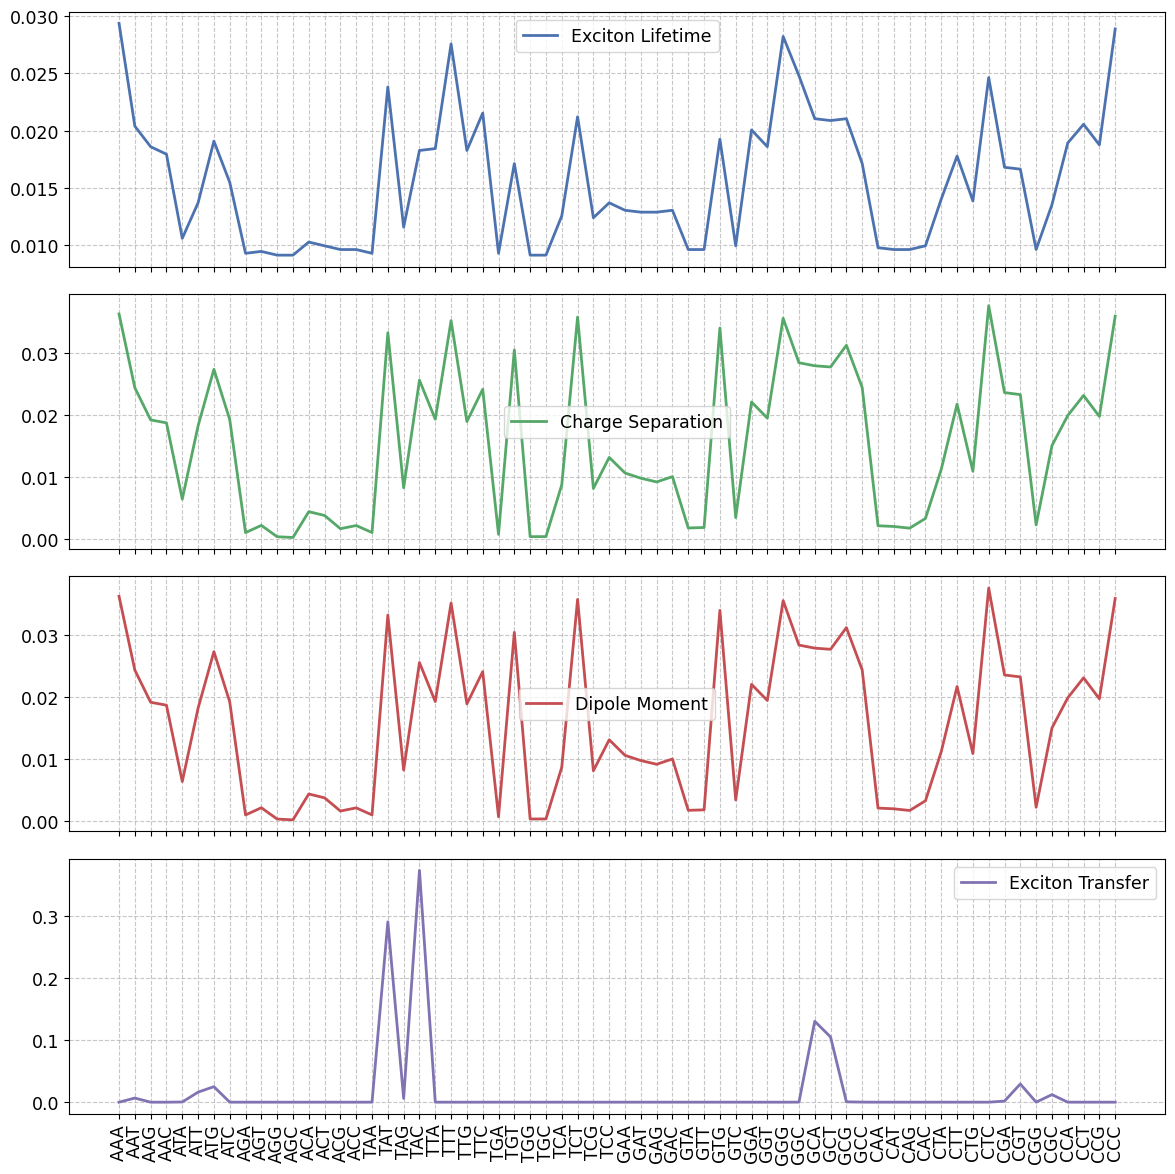

In [7]:
import seaborn as sns

def normalize_dict_values(data):
    total = sum(data.values())
    return {key: value / total for key, value in data.items()}

dicts = [normalize_dict_values(dictionary) for dictionary in [lifetime_dict, dipole_dict, dipole_moment_dict, exciton_transfer_lower_dict]]
labels = ['Exciton Lifetime', 'Charge Separation', 'Dipole Moment', 'Exciton Transfer']
colors = sns.color_palette()[:4]

fig, ax = plt.subplots(4, 1, figsize=(12,12), sharex=True)
for i in range(4):
    dictionary = dicts[i]
    ax[i].plot(range(64), dictionary.values(), label=labels[i], color=colors[i])
    ax[i].legend()
    
dna_seqs = list(lifetime_dict.keys())
ax[-1].set_xticks(range(64), labels=dna_seqs, rotation=90)

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

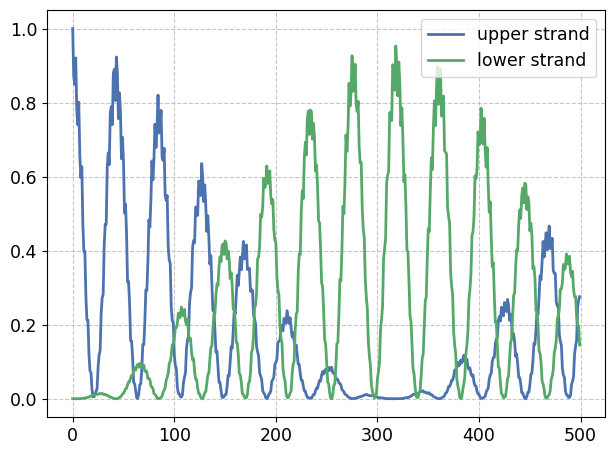

In [8]:
# The analysis above shows there are some intersting triplet sequences (TAT, TAC, GCA, GCT). Let's have a closer look.
from qDNA import calc_exciton_transfer

upper_strand ='GCT'
tb_model_name = 'ELM'
kwargs = dict(particles=['exciton'])

pop_upper_strand, pop_lower_strand = calc_exciton_transfer(upper_strand, tb_model_name, average=False, **kwargs)

fig, ax = plt.subplots()
ax.plot(pop_upper_strand['exciton'], label='upper strand')
ax.plot(pop_lower_strand['exciton'], label='lower strand')
ax.legend()

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

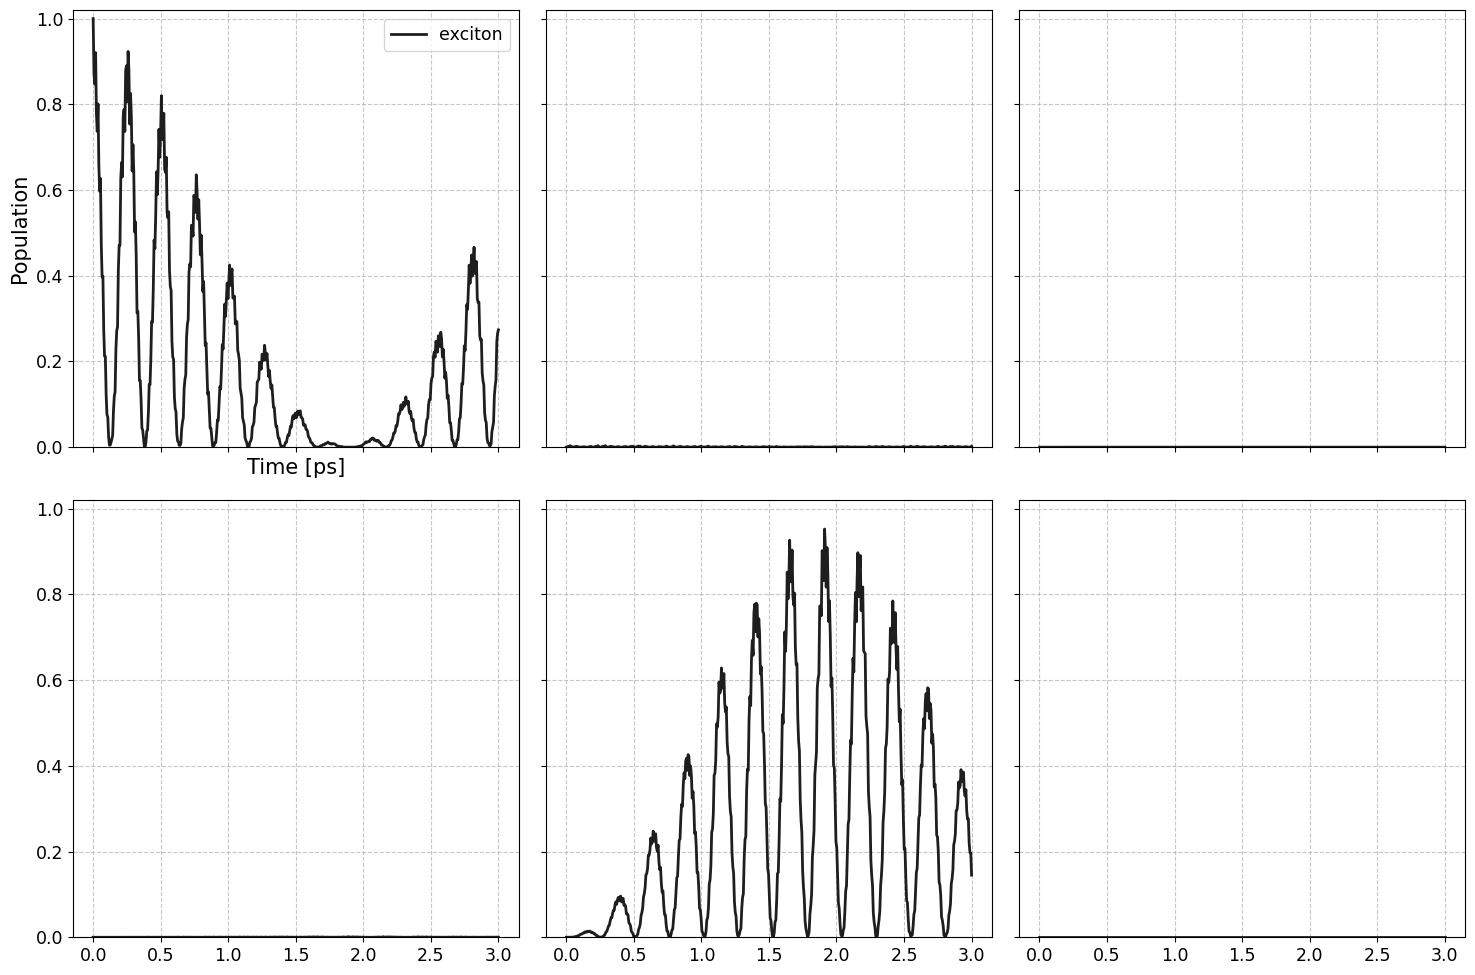

In [9]:
# we observe how the exciton gets transferred to the lower strand

from qDNA import get_me_solver, plot_pops

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)

fig, ax = plot_pops(me_solver)

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))